<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: Real or Fake Jobs

## Contents:
### Part 1 (of 3)
- [Problem Statement](#Problem-Statement)
- [Background](#Background)
- [Data Cleaning](#Data-Cleaning)
- [Data Dictionary](#Data-Dictionary)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- Data Modelling
    - Model Fitting & Evaluation
- Data Modelling with SMOTE
    - Model Fitting & Evaluation (SMOTE)
- Model Selection
- Misclassified Data
- Topic Modelling
- Conclusions
- Recommendations
- References

## Problem Statement
Given the increasing number of job scams, especially during the COVID-19 pandemic, we aim to train several classification models including Logistic Regression, Random Forest and Naive Bayes before selecting the best classifier to predict whether jobs are real or fake to prevent job-seekers from falling into job scams. The classifier will be incorporated to job portals such that if a job ad is predicted to be fraudulent or fake, the listing will not be published on the portal. A successful model would be one with a high ROC AUC score (>0.9) and high recall score. We want to minimise the False Negatives as the impact of incorrectly predicting a fraudulent job as a genuine might lead to job-seekers falling prey to job scams and put them in a worse situation that what they are already facing.


## Background
The COVID-19 pandemic has caused unemployment rate to increase due to the economic slowdown. As a result, many are left unemployed and vulnerable, becoming easy targets for job scammers. The Better Business Bureau has reported more than 13,000 job listing scams in North America alone between December 2019 to April 2020. An annual [Flexjob survey](https://www.flexjobs.com/blog/post/how-to-find-a-real-online-job-and-avoid-the-scams-v2/) found that more than 80% of job seekers report being on guard or very concerned about scams on other job boards. According to the same survey, almost 20% of job seekers have been a victim of a job scam (up from 13% in 2016), with 22% of job seekers knowing somebody who has been victim of a job scam.

There are some generic indicators of job listings which are fraudulent such as:
- Grammatical or spelling errors
- High paying jobs with low requirements
- Urgency to fill the position
- Requiring sensitive info/upfront payment 

However, there may be other factors which are not so direct in determining that the job listing is fradulent. Furthermore, it is easy for anyone to publish job ads on job portals or messaging apps today, regardless of whether the job is genuine or fraudulent.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
import string
import re
import nltk
from langdetect import detect
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max.columns', None)
pd.set_option('display.max.colwidth', 100)

In [2]:
# remove the warnings in the output
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action = 'ignore', category = SettingWithCopyWarning)

## Data Cleaning

In [3]:
# load and store the data file as a dataframe
df = pd.read_csv('../data/fake_job_postings.csv')

In [4]:
# display top 5 rows
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, con...","Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and cu...",Experience with content management systems a major plus (any blogging counts!)Familiar with the ...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Produ...",Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing...,"What we expect from you:Your key responsibility will be to communicate with the client, 90 Secon...",What you will get from usThrough being part of the 90 Seconds team you will gain:experience work...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions that meet the needs of companies across the Private ...,"Our client, located in Houston, is actively seeking an experienced Commissioning Machinery Assis...",Implement pre-commissioning and commissioning procedures for rotary equipment.Execute all activi...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life through geography is at the heart of everything we do....,THE COMPANY: ESRI – Environmental Systems Research InstituteOur passion for improving quality of...,"EDUCATION: Bachelor’s or Master’s in GIS, business administration, or a related field, or equiva...","Our culture is anything but corporate—we have a collaborative, creative environment; phone direc...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Capital Management Consulting firm headquartered in M...,"JOB TITLE: Itemization Review ManagerLOCATION: Fort Worth, TX ...","QUALIFICATIONS:RN license in the State of TexasDiploma or Bachelors of Science in Nursing, requi...",Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
# check shape
df.shape

(17880, 18)

In [6]:
# check for nulls
df.isnull().sum().sort_values(ascending = False)

salary_range           15012
department             11547
required_education      8105
benefits                7210
required_experience     7050
function                6455
industry                4903
employment_type         3471
company_profile         3308
requirements            2695
location                 346
description                1
job_id                     0
telecommuting              0
has_questions              0
has_company_logo           0
title                      0
fraudulent                 0
dtype: int64

In [7]:
# drop salary_range, department as >50% of data are missing
# drop job_id as not relevant
df = df.drop(columns = ['salary_range', 'department', 'job_id'])

### Data Imputation

In [8]:
# backfill null values
df['required_education'].bfill(axis = 0, inplace = True)
df['required_experience'].bfill(axis = 0, inplace = True)
df['employment_type'].bfill(axis = 0, inplace = True)

In [9]:
# if industry is na, impute with function
df['industry'].fillna(df['function'], inplace = True)

In [10]:
# convert company_profile from unstructured data to a binary columns where 1 is yes and 0 is no
df.loc[df['company_profile'].notna(), 'company_profile'] = 1
df['company_profile'].fillna(0, inplace = True)

In [11]:
# fillna of requirements and benefits with ''
df['requirements'].fillna('', inplace = True)
df['benefits'].fillna('', inplace = True)

In [12]:
# drop function as no longer required
df.drop(columns = ['function'], inplace = True)

In [13]:
# check nulls again
df.isnull().sum()

title                     0
location                346
company_profile           0
description               1
requirements              0
benefits                  0
telecommuting             0
has_company_logo          0
has_questions             0
employment_type           0
required_experience       0
required_education        1
industry               3970
fraudulent                0
dtype: int64

In [14]:
# drop the remaining nulls
df = df.dropna()

In [15]:
# final check on nulls - should be all 0
df.isnull().sum()

title                  0
location               0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
fraudulent             0
dtype: int64

In [16]:
# check shape after data cleaning
df.shape

(13791, 14)

**Observation**: While we dropped about 20% of missing values from the dataframe, we still have quite a large amount of data (>13k rows) to work with, so this should not be a major issue.

### Grouping Similar Categories of Data

In [17]:
df['required_education'].value_counts()

Bachelor's Degree                    7317
High School or equivalent            2791
Unspecified                          2063
Master's Degree                       583
Associate Degree                      400
Certification                         244
Some College Coursework Completed     138
Professional                          100
Vocational                             66
Doctorate                              35
Some High School Coursework            29
Vocational - HS Diploma                15
Vocational - Degree                    10
Name: required_education, dtype: int64

In [18]:
# group all the education level containing 'vocational' as one
df['required_education'] = np.where(df['required_education'].isin(['Vocational - HS Diploma', 'Vocational - Degree']),
                                   'Vocational', df['required_education'])

# group 'some high school coursework' together with 'high school or equivalent'
df.replace({'Some High School Coursework': 'High School or equivalent'}, inplace = True)


In [19]:
df['industry'].value_counts()

Information Technology and Services    1718
Computer Software                      1363
Internet                               1048
Education Management                    822
Marketing and Advertising               821
                                       ... 
Wine and Spirits                          1
Distribution                              1
Legal                                     1
Training                                  1
Ranching                                  1
Name: industry, Length: 163, dtype: int64

In [20]:
# create a industry_grp column which copies the industry column
df['industry_grp'] = df['industry']

# group industries into more general groups
# group ICT
df['industry_grp'] = np.where(df['industry'].isin(['Information Services', 'Information Technology', 
                                                   'Information Technology and Services']), 
                              'ICT', df['industry_grp'])

# group Computer Prog
df['industry_grp'] = np.where(df['industry'].isin(['Computer & Network Security', 'Computer Games', 
                                                   'Computer Hardware','Computer Networking', 'Computer Software']), 
                              'Computer Prog', df['industry_grp'])


# group Financial Services
df['industry_grp'] = np.where(df['industry'].isin(['Finance', 'Financial Analyst', 'Investment Banking', 'Insurance',
                                                   'Investment Management', 'Banking', 'Capital Markets',
                                                   'Venture Capital & Private Equity']), 
                              'Financial Services', df['industry_grp'])

# group Education
df['industry_grp'] = np.where(df['industry'].isin(['Higher Education', 'Primary/Secondary Education', 'E-Learning',
                                                   'Education Management', 'Training', 
                                                   'Professional Training & Coaching']),
                              'Education', df['industry_grp'])

# group Broadcasting/Publishing
df['industry_grp'] = np.where(df['industry'].isin(['Animation', 'Distribution', 'Media Production', 'Internet', 
                                                   'Printing', 'Motion Pictures and Film', 'Online Media', 
                                                   'Broadcast Media', 'Publishing', 'Writing and Editing', 
                                                   'Writing/Editing', 'Photography']),
                              'Broadcasting/Publishing', df['industry_grp'])

# group Arts & Entertainment
df['industry_grp'] = np.where(df['industry'].isin(['Museums and Institutions', 'Music', 'Performing Arts', 'Sports',
                                                   'Art/Creative','Design', 'Graphic Design', 'Entertainment', 
                                                   'Gambling & Casinos', 'Libraries', 'Religious Institutions', 
                                                   'Philanthropy', 'Leisure, Travel & Tourism', 'Hospitality']), 
                              'Arts & Entertainment', df['industry_grp']) 
                 
# # group Healthcare
df['industry_grp'] = np.where(df['industry'].isin(['Hospital & Health Care', 'Mental Health Care', 
                                                   'Health Care Provider', 'Health, Wellness and Fitness', 
                                                   'Medical Devices', 'Medical Practice']),
                              'Healthcare', df['industry_grp'])

# group Marketing/Advertising
df['industry_grp'] = np.where(df['industry'].isin(['Marketing', 'Marketing and Advertising', 'Research', 
                                                   'Advertising', 'Market Research']), 
                              'Marketing/Advertising', df['industry_grp'])

# group F&B
df['industry_grp'] = np.where(df['industry'].isin(['Food & Beverages', 'Food Production', 'Restaurants', 
                                               'Wine and Spirits']), 
                              'F&B', df['industry_grp'])
            
# group Legal & Accounting
df['industry_grp'] = np.where(df['industry'].isin(['Accounting', 'Accounting/Auditing', 'Legal Services', 'Legal',
                                                   'Law Enforcement', 'Law Practice', 
                                                   'Alternative Dispute Resolution']), 
                              'Legal & Accounting', df['industry_grp'])

# group Business/Consultancy
df['industry_grp'] = np.where(df['industry'].isin(['Business Analyst', 'Business Development', 'Consulting', 
                                                   'Management', 'Business Supplies and Equipment', 'Maritime',
                                                   'General Business', 'Product Management', 'Project Management', 
                                                   'Executive Office', 'Management Consulting', 'Data Analyst']),
                              'Business/Consultancy', df['industry_grp'])

# group Social Services
df['industry_grp'] = np.where(df['industry'].isin(['Individual & Family Services', 'Civic & Social Organization']), 
                              'Social Services', df['industry_grp'])

# group Public Admin
df['industry_grp'] = np.where(df['industry'].isin(['Defense & Space', 'Fund-Raising', 'Military', 
                                                   'Government Relations', 'Government Administration', 
                                                   'Public Relations', 'Public Safety', 'Public Policy',
                                                   'Nonprofit Organization Management', 
                                                   'Public Relations and Communications']), 
                              'Public Admin', df['industry_grp'])

# group Admin/HR
df['industry_grp'] = np.where(df['industry'].isin(['Administrative', 'Customer Service', 'Human Resources', 
                                                   'Program Development', 'Staffing and Recruiting', 
                                                   'Events Services']),
                              'Admin/HR', df['industry_grp'])
            
# group Wholesale/Retail
df['industry_grp'] = np.where(df['industry'].isin(['Apparel & Fashion', 'Cosmetics', 'Retail', 'Sporting Goods',
                                                   'Luxury Goods & Jewelry','Sales', 'Warehousing', 'Wholesale']), 
                              'Wholesale/Retail', df['industry_grp'])

# group Transportation & Storage
df['industry_grp'] = np.where(df['industry'].isin(['Airlines/Aviation', 'Aviation & Aerospace', 'Import and Export', 
                                                   'Supply Chain', 'International Trade and Development', 
                                                   'Logistics and Supply Chain', 'Package/Freight Delivery',
                                                   'Packaging and Containers', 'Translation and Localization', 
                                                   'Transportation/Trucking/Railroad']),
                              'Transportation & Storage', df['industry_grp'])
            

# group Construction
df['industry_grp'] = np.where(df['industry'].isin(['Building Materials', 'Shipbuilding']), 
                              'Construction', df['industry_grp'])

# group Manufacturing
df['industry_grp'] = np.where(df['industry'].isin(['Automotive', 'Chemicals', 'Consumer Electronics','Consumer Goods',
                                                   'Consumer Services', 'Electrical/Electronic Manufacturing', 
                                                   'Furniture', 'Industrial Automation', 'Machinery', 
                                                   'Pharmaceuticals', 'Plastics', 'Production', 'Quality Assurance', 
                                                   'Semiconductors', 'Textiles', 'Wireless']), 
                              'Manufacturing', df['industry_grp'])
      
# group Architecture & Engineering
df['industry_grp'] = np.where(df['industry'].isin(['Civil Engineering', 'Mechanical or Industrial Engineering', 
                                                   'Architecture & Planning', 'Design', 'Environmental Services',
                                                   'Engineering']), 
                              'Architecture & Engineering', df['industry_grp'])

# group Scientific R&D
df['industry_grp'] = np.where(df['industry'].isin(['Biotechnology', 'Nanotechnology', 'Science']),
                              'Scientific R&D', df['industry_grp'])

# group Real Estate
df['industry_grp'] = np.where(df['industry'].isin(['Commercial Real Estate', 'Facilities Services']), 
                              'Real Estate', df['industry_grp'])
            
# group Others
df['industry_grp'] = np.where(df['industry'].isin(['Farming', 'Fishery', 'Mining & Metals', 'Other', 
                                                   'Outsourcing/Offshoring', 'Ranching', 'Renewables & Environment', 
                                                   'Utilities', 'Veterinary']), 
                              'Others', df['industry_grp'])

### Pre-processing of text column
1. We first combine `title`, `description` and `requirements` into a single `text` column.
2. We remove non-english job ads, links, non-alphabetic characters, stopwords and lemmatized the texts.

In [21]:
# combined textual data to a single column
df['text'] = df['title'] + ' ' + df['description'] + ' ' + df['requirements'] 

In [22]:
# create a new column to detect the language of the job-ads
df['language'] = df['text'].apply(lambda x: detect(x))

In [23]:
# remove non-english text
df = df[df['language'] == 'en']

In [24]:
# removing links (https://www...) from the text column
df['text_nolinks'] = df['text'].replace([r'https:\S+', r'http:\S+', r'www\S+', r'#URL_\S+'], '', regex = True)

In [25]:
# write a function to remove characters that are not alphan, i.e. punctuations/symbols
def remove_non_alpha(text):
    """
    This function will take in a string of texts, replace the characters that are not alphabets with space, 
    remove extra spacing between words, or when spacing is the first/last character, 
    and convert the string of texts to lowercase.
    """
    alpha = re.sub('[^a-zA-Z]', ' ', text)
    
    # remove myltiple spacing
    alpha_clean = re.sub(' +', ' ', alpha)
    chars = alpha_clean.lstrip().rstrip().lower()
    text_alpha = ''.join([char for char in chars])
    return text_alpha

In [26]:
# remove non-alphabetic characters
df['text_alpha'] = df['text_nolinks'].apply(lambda x: remove_non_alpha(x))

In [27]:
# write a function to tokenize text, and remove stopwords
def token_nostop(text):
    """
    This function will take in a string of texts and separate them into a list of individual words (tokenize).
    It will then remove stopwords from the built-in nltk package, and additional user pre-defined stopwords.
    """
    tokens = re.split('\W+', text)
    stopwords = nltk.corpus.stopwords.words('english')
    
    # include additional stopwords which we want to remove
    additional_stopwords = ['link', 'amp', 'email', 'address', 'apply', 'team', 'work', 'html', 'must', 'able',
                            'customer', 'service', 'product', 'company', 'ability', 'attention', 'detail', 'serif',
                            'communication', 'hour', 'per', 'week', 'year', 'experience', 'full', 'time', 'pm',
                            'either', 'entity', 'information', 'include', 'etc']
    stopwords.extend(additional_stopwords)
    
    tokens_nostop = [word for word in tokens if word not in stopwords]
    return tokens_nostop

In [28]:
# remove stopwords
df['text_nostop'] = df['text_alpha'].apply(lambda x: token_nostop(x))

**Note**: As stemming and lemmatization are rather similar, there is no need to perform both types of data cleaning. In this case, we will perform lemmatization as it will return the root word which is in the proper english dictionary form. This will enable more informed analysis and is more accurate than stemming.

In [29]:
# write a function to perform lemmatization
wn = nltk.WordNetLemmatizer()
def lemmatizing(tokenized_text):
    """
    This function will take in string of texts and return their corresponding lemmas.
    """
    text_lemmatized = ' '.join([wn.lemmatize(word) for word in tokenized_text])
    return text_lemmatized

In [30]:
# lemmatize text
df['text_lemma'] = df['text_nostop'].apply(lambda x: lemmatizing(x))

In [31]:
# create a column word_length to check the number of words in each post
df['word_length'] = df['text_nostop'].apply(lambda x: len(x))

# display top 2 rows of df with shortest number of words in posts
df.sort_values(by = 'word_length').head(2)

,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,fraudulent,industry_grp,text,language,text_nolinks,text_alpha,text_nostop,text_lemma,word_length
5188,web designer,"GR, I, Athens",1,#URL_f4b388afcf7084d0a2a87cf2c1b7801edb9fe831ee34343b22cf532ee34ca5b7# is looking for a web desi...,PhotoshopBootstrapGit,,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Internet,0,Broadcasting/Publishing,web designer #URL_f4b388afcf7084d0a2a87cf2c1b7801edb9fe831ee34343b22cf532ee34ca5b7# is looking f...,en,web designer is looking for a web designer for full time employment. PhotoshopBootstrapGit,web designer is looking for a web designer for full time employment photoshopbootstrapgit,"[web, designer, looking, web, designer, employment, photoshopbootstrapgit]",web designer looking web designer employment photoshopbootstrapgit,7
7316,Ux desgin,"US, NY, NY",0,Best UX job in the world,Axureillustrator,"10,000$",0,0,1,Full-time,Entry level,Bachelor's Degree,Design,1,Architecture & Engineering,Ux desgin Best UX job in the world Axureillustrator,en,Ux desgin Best UX job in the world Axureillustrator,ux desgin best ux job in the world axureillustrator,"[ux, desgin, best, ux, job, world, axureillustrator]",ux desgin best ux job world axureillustrator,7


In [32]:
# create a column char_length to check the number of characters in each post
df['char_length'] = df['text_lemma'].apply(lambda x: len(x))

# display top 2 rows of df with shortest number of characters in posts
df.sort_values(by = 'char_length').head(2)

,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,fraudulent,industry_grp,text,language,text_nolinks,text_alpha,text_nostop,text_lemma,word_length,char_length
7316,Ux desgin,"US, NY, NY",0,Best UX job in the world,Axureillustrator,"10,000$",0,0,1,Full-time,Entry level,Bachelor's Degree,Design,1,Architecture & Engineering,Ux desgin Best UX job in the world Axureillustrator,en,Ux desgin Best UX job in the world Axureillustrator,ux desgin best ux job in the world axureillustrator,"[ux, desgin, best, ux, job, world, axureillustrator]",ux desgin best ux job world axureillustrator,7,44
17534,Photoshop master,"US, NY, NY",0,We need a Photoshop master - AE adventage...,PhotoshopAE,"12,000$",0,0,1,Full-time,Entry level,Some College Coursework Completed,Design,1,Architecture & Engineering,Photoshop master We need a Photoshop master - AE adventage... PhotoshopAE,en,Photoshop master We need a Photoshop master - AE adventage... PhotoshopAE,photoshop master we need a photoshop master ae adventage photoshopae,"[photoshop, master, need, photoshop, master, ae, adventage, photoshopae]",photoshop master need photoshop master ae adventage photoshopae,8,63


In [33]:
# drop columns that we no longer need
df.drop(columns = ['title', 'description', 'requirements', 'benefits',
                  'text', 'text_nolinks', 'text_alpha', 'text_nostop', 'language', 'location'], inplace = True)

In [34]:
# check for duplicates
df[df.duplicated()]

,company_profile,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,fraudulent,industry_grp,text_lemma,word_length,char_length
41,1,0,1,1,Contract,Entry level,Bachelor's Degree,Education Management,0,Education,english teacher abroad play kid get paid love travel job asia usd monthly cost living housing pr...,41,306
48,1,0,1,1,Contract,Entry level,Bachelor's Degree,Education Management,0,Education,english teacher abroad play kid get paid love travel job asia usd monthly cost living housing pr...,41,306
62,1,0,1,1,Contract,Entry level,Bachelor's Degree,Education Management,0,Education,english teacher abroad play kid get paid love travel job asia usd monthly cost living housing pr...,41,306
80,1,0,1,1,Contract,Entry level,Bachelor's Degree,Education Management,0,Education,english teacher abroad play kid get paid love travel job asia usd monthly cost living housing pr...,41,306
99,1,0,1,1,Contract,Entry level,Bachelor's Degree,Education Management,0,Education,english teacher abroad play kid get paid love travel job asia usd monthly cost living housing pr...,41,306
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17800,0,0,0,0,Full-time,Entry level,High School or equivalent,Hospital & Health Care,1,Healthcare,admin assistant job descriptionadministrative assistantdescriptionan insurance consulting practi...,79,723
17806,0,0,0,0,Full-time,Entry level,High School or equivalent,Animation,1,Broadcasting/Publishing,front office manager reception looking employee manage front desk physical therapy fitness facil...,85,689
17811,1,0,1,0,Full-time,Associate,High School or equivalent,Financial Services,1,Financial Services,agency sale manager yr provide credit check financing customer small medium size business help i...,78,580
17813,1,1,1,0,Full-time,Entry level,High School or equivalent,Real Estate,1,Real Estate,representative seeking candidate whose core value integrity compassion responsibility focused bu...,39,349


In [35]:
# drop duplicates and check that shape have decreased
print(f'Shape of df before removing duplicates: {df.shape}')
df = df.drop_duplicates()
print(f'Shape of df after removing duplicates: {df.shape}')

Shape before removing duplicates (13700, 13)
Shape after removing duplicates (12377, 13)


In [36]:
# remove duplicates from text_lemma column (if any) 
print(f'Shape of df before removing duplicates: {df.shape}')
df.drop_duplicates(subset = ['text_lemma'], inplace = True)
print(f'Shape of df after removing duplicates: {df.shape}')

Shape of df before removing duplicates: (12377, 13)
Shape of df after removing duplicates: (11867, 13)


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11867 entries, 0 to 17878
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   company_profile      11867 non-null  int64 
 1   telecommuting        11867 non-null  int64 
 2   has_company_logo     11867 non-null  int64 
 3   has_questions        11867 non-null  int64 
 4   employment_type      11867 non-null  object
 5   required_experience  11867 non-null  object
 6   required_education   11867 non-null  object
 7   industry             11867 non-null  object
 8   fraudulent           11867 non-null  int64 
 9   industry_grp         11867 non-null  object
 10  text_lemma           11867 non-null  object
 11  word_length          11867 non-null  int64 
 12  char_length          11867 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.3+ MB


In [38]:
# reorder the columns
df = df[['company_profile', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
         'required_experience', 'required_education', 'industry', 'industry_grp', 'text_lemma', 
         'word_length','char_length', 'fraudulent']]

## Data Dictionary

|Feature            |Type     |Description|
|-------------------|---------|-----------| 
|company_profile    |*integer*|Whether the Job Posting comes with a Company Profile (1 if yes; 0 if no)|
|telecommuting      |*integer*|Whether the Job offers Telecommuting Option (1 if yes; 0 if no)|
|has_company_logo   |*integer*|Whether the Job Posting comes with a Company Logo (1 if yes; 0 if no)|
|has_questions      |*integer*|Whether there are Interview Questions (1 if yes; 0 if no)|
|employment_type    |*object* |Type of Employment|
|required_experience|*object* |Minimum Expereience required for the Job|
|required_education |*object* |Minimum Education Level required for the Job|
|industry           |*object* |Industry of the Job|
|industry_grp       |*object* |Grouped Industry of the Job |
|text_lemma         |*object* |Lemmatized form of combined info on Job Title, Job Description and Requirements|
|word_length        |*integer* |Number of Words in text_lemma|
|char_length        |*integer* |Number of Characters in text_lemma|
|fraudulent         |*integer*|**Target Variable** - Whether a Job Posting is fraudulent (1 if yes; 0 if no)|


## Exploratory Data Analysis

In [39]:
# map integer labels to string labels to aid visualisations
df['fraudulent'] = df['fraudulent'].map({0: 'Real', 1: 'Fake'})

In [40]:
# proportion of the two classes
df['fraudulent'].value_counts(normalize = True)

Real    0.959046
Fake    0.040954
Name: fraudulent, dtype: float64

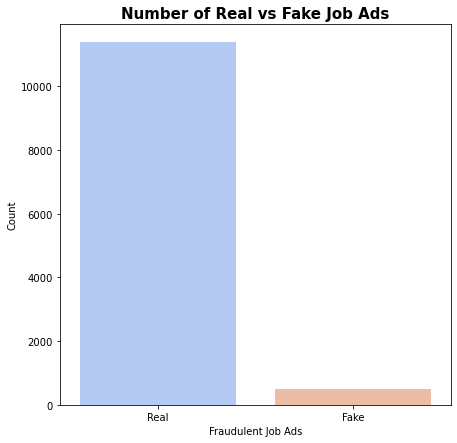

In [41]:
# visualise count plot of target variable
plt.figure(figsize = (7, 7))
sns.countplot(data = df, x = 'fraudulent', palette = 'coolwarm')
plt.title('Number of Real vs Fake Job Ads', fontweight = 'bold', fontsize = 15)
plt.ylabel('Count')
plt.xlabel('Fraudulent Job Ads');

plt.savefig('../image/real-fake-jobs.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: This is a highly unbalanced dataset, with 96% of real job ads and only 4% of fake job ads.

In [42]:
# filter the df to separate the two classes
fake_jobs = df.loc[df['fraudulent'] == 'Fake']
real_jobs = df.loc[df['fraudulent'] == 'Real'] 

In [43]:
# write a function to plot the countplots of features
def countplots(feature):
    """
    This function takes in the feature and returns the countplots of feature against 
    Fake Jobs and Real Jobs respectively.
    """
    plt.figure(figsize = (16, 8))
    
    # fake_jobs plots
    plt.subplot(1,2,1)
    sns.countplot(data = fake_jobs, y = feature, palette = 'coolwarm',
                 order = fake_jobs[feature].value_counts().index)
    plt.title(f'Count Plot of {feature} in Fake Job Ads', fontweight = 'bold', fontsize = 15)
    plt.ylabel(feature, fontsize = 14)
    plt.xlabel('Count', fontsize = 14)
    plt.tight_layout();
    
    # real_jobs plots
    plt.subplot(1,2,2)
    sns.countplot(data = real_jobs, y = feature, palette = 'coolwarm',
                 order = real_jobs[feature].value_counts().index)
    plt.title(f'Count plot of {feature} in Real Job Ads', fontweight = 'bold', fontsize = 15)
    plt.ylabel(feature, fontsize = 14)
    plt.xlabel('Count', fontsize = 14)
    plt.tight_layout();

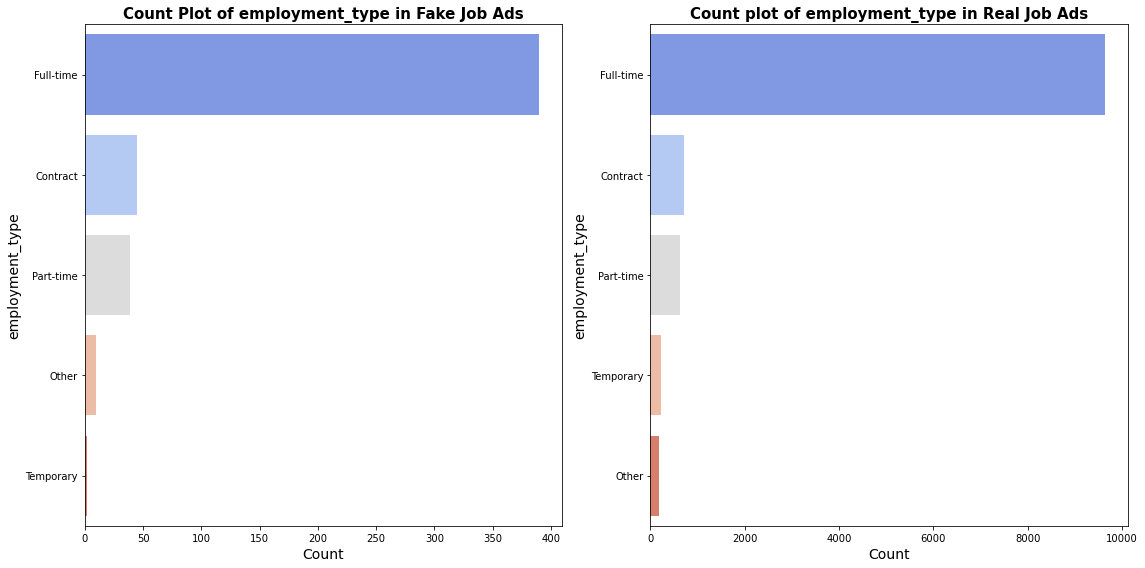

In [44]:
# visualise count plots of employment type by real/fake job ads
countplots('employment_type')
plt.savefig('../image/employment-type-by-target.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: Most of the jobs were looking for full-time positions, regardless of whether the job listings were real or fake. This is likely because full-time positions usually attract more applicants as they come with more benefits and job security. Since the trend is the same for both real and fake jobs, this feature might not be very useful to be included in our model.

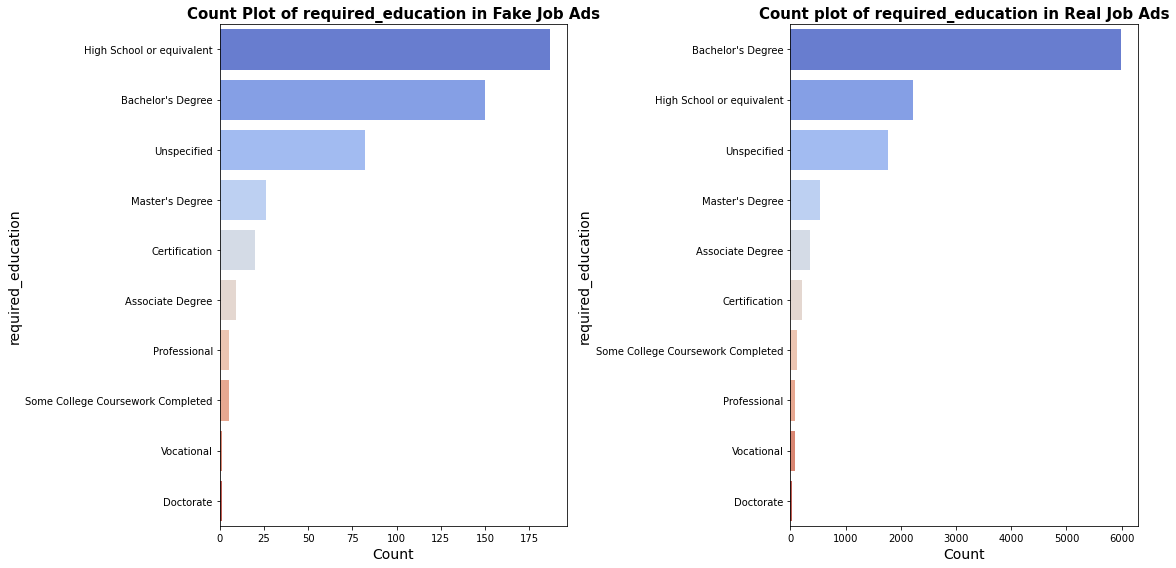

In [45]:
# visualise count plots of required_education by real/fake job ads
countplots('required_education')
plt.savefig('../image/required-education-by-target.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: Most of the fake jobs only required high school or equivalent qualifications. This is a rather easy requirement to meet, which makes it an attractive point since many job-seekers will be able to fulfil this criteria as compared to real jobs which requires a higher level of qualification such as a Bacherlor's Degree.

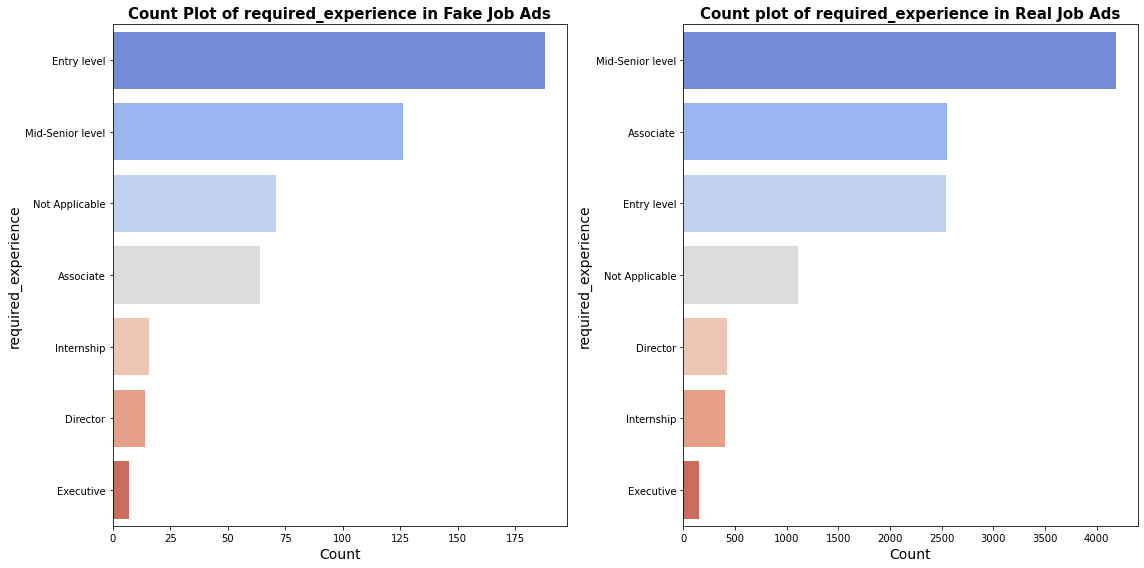

In [46]:
# visualise count plots of required_experience by real/fake job ads
countplots('required_experience')
plt.savefig('../image/required-experience-by-target.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: Most of the fake jobs only require applicants to have entry-level experience. Similarly, this is an easy requirement to meet, as it suggests that applicants do not need any prior expereince. This increases the application rate as many job-seekers will be able to fulfil this criteria, as compared to requiring a Mid-Senior level for real jobs.

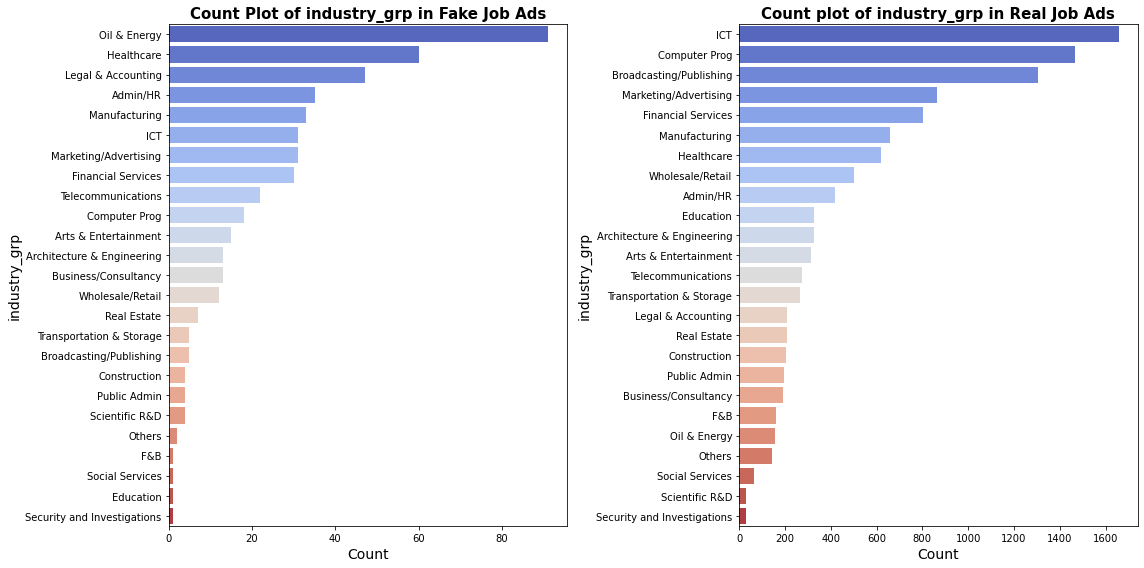

In [47]:
# visualise count plots of industry_grp by real/fake job ads
countplots('industry_grp')
plt.savefig('../image/industry-by-target.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: The industry that is commonly listing fake job ads are Oil & Energy, Healthcare and Legal & Accounting. This is surprising as these areas are quite niche and we would not expect the job frauds to be from these industries.

In [48]:
# write a function to plot the binary columns by target
def subplots(x):
    """
    This function takes in the feature and returns the plots of feature against Fake Jobs and Real Jobs respectively.
    """
    plt.figure(figsize = (16, 8))
    
    # fake_jobs plots
    plt.subplot(2,2,1)
    ax1 = sns.countplot(data = fake_jobs, x = x, palette = 'coolwarm')
    plt.title(f'{x} in Fake Jobs', fontweight = 'bold', fontsize = 15)
    plt.ylabel('Count', fontsize = 14)
    plt.xlabel(x, fontsize = 14)
    plt.tight_layout();
    
    # real_jobs plots
    plt.subplot(2,2,2)
    ax2 = sns.countplot(data = real_jobs, x = x, palette = 'coolwarm')
    plt.title(f'{x} in Real Jobs', fontweight = 'bold', fontsize = 15)
    plt.ylabel('Count', fontsize = 14)
    plt.xlabel(x, fontsize = 14)
    plt.tight_layout();

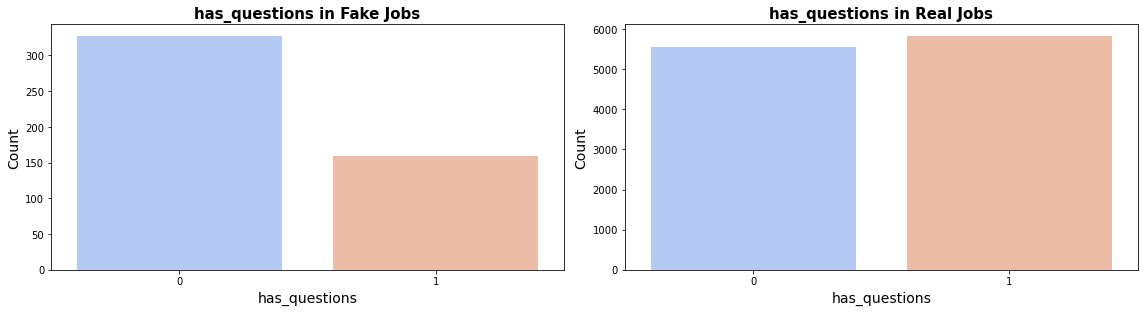

In [49]:
# visualise countplots of has_questions by fake/real jobs
subplots('has_questions')
plt.savefig('../image/has-questions-by-target.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: Among real jobs, 1 in 2 jobs were accompanied by interview questions. However, among fake jobs, the proportion of jobs which did not require interview is about 1.5x that of those which required interview. This means that for fake jobs, the hiring process is much simpler where no interviews are required.

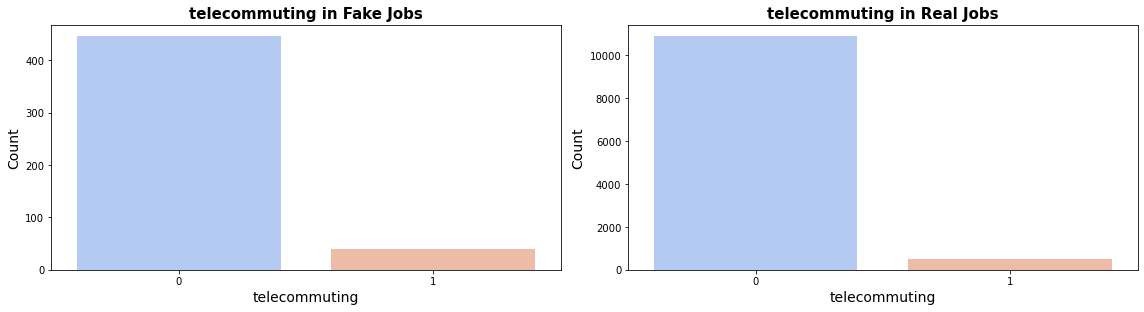

In [50]:
# visualise countplots of telecommuting by fake/real jobs
subplots('telecommuting')
plt.savefig('../image/telecommuting-by-target.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: Most jobs generally do not offer telecommuting as an option, regardless of whether the job was real or fake.

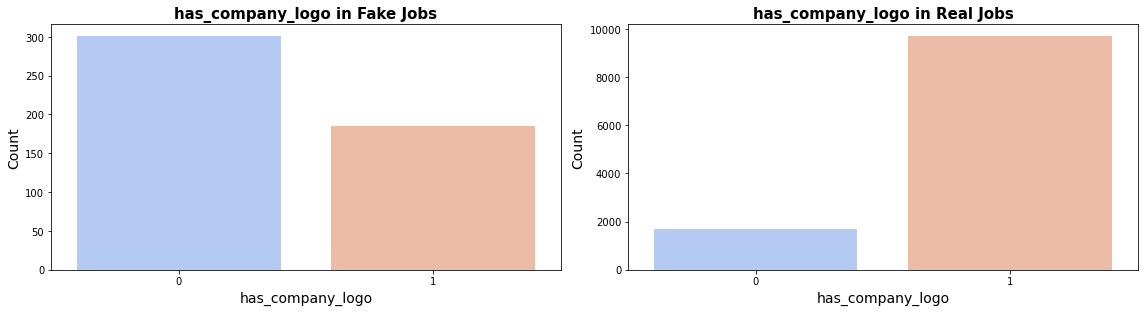

In [51]:
# visualise countplots of has_company_logo by fake/real jobs
subplots('has_company_logo')
plt.savefig('../image/has-logo-by-target.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: The proportion of real jobs with company logo is significantly higher than real jobs without company logo. Having a company logo might be a good sign of the credibility of the job, as the company is putting out their brand/info on their company which applicants can look up for more details. On the other hand, many of the fake jobs did not have a company logo. This could be because the job scammers did not find it worth it to design a logo for a company that did not exist. While there are some fake jobs with a company logo, they could have been poorly designed just to create a impression that the job is real.

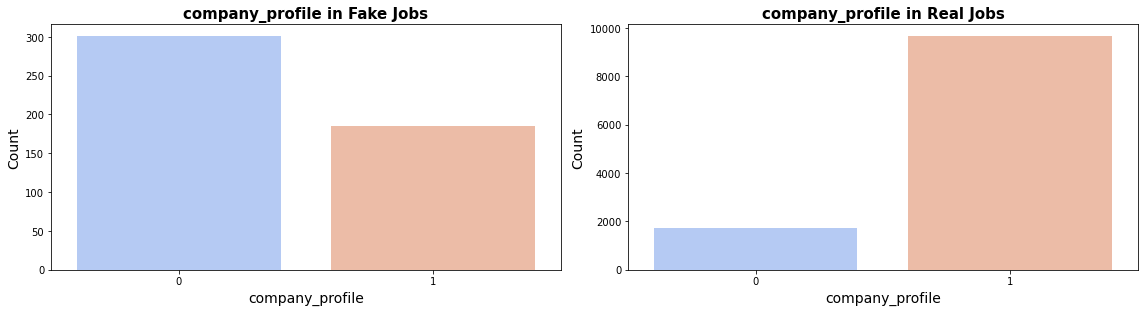

In [52]:
# visualise countplots of company_profile by fake/real jobs
subplots('company_profile')
plt.savefig('../image/has-profile-by-target.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: The proportion of real jobs with company profile is significantly higher than real jobs without company profile. Similar to having a company logo, having a company profile might be a good sign of the credibility of the job. On the other hand, there was a larger proportion of fake jobs without company profile than those with company profile.

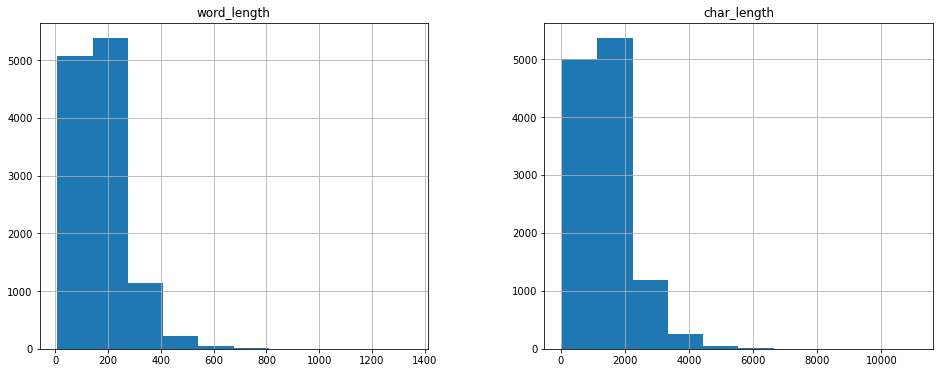

In [53]:
# visualise distribution of word_length and char_length
df[['word_length', 'char_length']].hist(figsize = (16, 6));
plt.savefig('../image/word-char-length.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: The distribution of both word_length and char_length are positively skewed as seen my the long right tail.

In [54]:
# summary statistics of word_length and char_length by real/fake jobs
df.groupby('fraudulent')[['word_length', 'char_length']].describe()

word_length                                                    \
                 count        mean         std  min    25%    50%    75%   
fraudulent                                                                 
Fake             486.0  152.288066  114.593334  7.0   69.0  117.0  199.5   
Real           11381.0  170.634566   93.888811  7.0  106.0  156.0  215.0   

                   char_length                                                \
               max       count         mean         std   min    25%     50%   
fraudulent                                                                     
Fake         852.0       486.0  1269.646091  970.892686  44.0  570.5   976.5   
Real        1345.0     11381.0  1407.829628  787.066339  65.0  861.0  1292.0   

                             
               75%      max  
fraudulent                   
Fake        1760.0   7097.0  
Real        1780.0  11041.0

**Observation**: The average word length and character length for real job ads are longer than those of fake job ads.

### Correlation with Target Variable

In [55]:
# unmap labels so that correlation w target can be computed
df['fraudulent'] = df['fraudulent'].map({'Real': 0, 'Fake': 1})
df.corr()

,company_profile,telecommuting,has_company_logo,has_questions,word_length,char_length,fraudulent
company_profile,1.000000,-0.056230,0.735189,0.178735,0.102415,0.110046,-0.246663
telecommuting,-0.056230,1.000000,-0.042057,0.021783,-0.014976,-0.022841,0.036143
has_company_logo,0.735189,-0.042057,1.000000,0.212194,0.111879,0.113145,-0.251672
has_questions,0.178735,0.021783,0.212194,1.000000,0.059102,0.047485,-0.073335
word_length,0.102415,-0.014976,0.111879,0.059102,1.000000,0.990323,-0.038320
char_length,0.110046,-0.022841,0.113145,0.047485,0.990323,1.000000,-0.034412
fraudulent,-0.246663,0.036143,-0.251672,-0.073335,-0.038320,-0.034412,1.000000


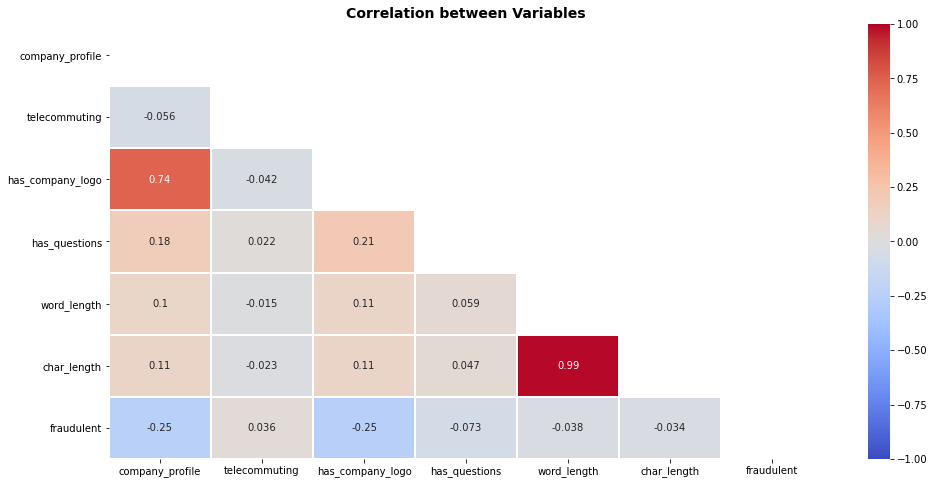

In [56]:
# plot heatmap to visualise correlation between variables
plt.figure(figsize = (16, 8))

# returns the lower triangle of any matrix
matrix = np.triu(df.corr()) 
heatmap = sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1, center = 0, 
                      cmap = 'coolwarm', linewidths = 2, linecolor = 'white', mask = matrix);
heatmap.set_title('Correlation between Variables', fontsize = 14, fontweight = 'bold');

plt.savefig('../image/corr-heatmap.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

 **Observation**: There is a very strong correlation between word_length and 'char_length' (0.99). Similarly, there is a strong correlation between 'has_company_logo' and 'company_profile' (0.74). To prevent the issue of multicolinearity, we dropped `char_length` and `company_profile` as they have a lower correlation with the target variable (fraudulent). The variable with the strongest correlation with the target variable is `has_company_logo` at -0.25 while the other numerical variables seem to have weak correlation. Nonetheless, it might be worthwhile to explore whether including numerical variables along with the text variables in the model will improve model performance.

Based on our EDA findings, we have decided to drop the following features:
- char_length
- company_profile
- employment_type
- telecommuting
- industry

In [57]:
# further drop unnecessary columns
df.drop(columns = ['char_length', 'company_profile', 'employment_type', 'telecommuting', 'industry'], inplace = True)

In [58]:
df.head(1)

,has_company_logo,has_questions,required_experience,required_education,industry_grp,text_lemma,word_length,fraudulent
0,1,0,Internship,Bachelor's Degree,Marketing/Advertising,marketing intern food fast growing james beard award winning online food community crowd sourced...,152,0


### Count Vectorization
As we are including unstructured data in our model (`text_lemma`), we will need to vectorize the text to convert it to a sparse matrix that machine learning models can understand. We start off with Count Vectorization.
#### Cvec. Combined Data
We used the min_df and max_df parameters in count vectorizer to remove outliers (i.e. words that occur too frequently/too infrequently). In this case, we removed words that appear more than 60% and words that appear less than 2% in the corpus.

In [59]:
# create an instance of CountVectorizer
count_vect = CountVectorizer(min_df = 0.02, max_df = 0.6)

# create a sparse matrix on text data
cvec_combined = count_vect.fit_transform(df['text_lemma'])
print(cvec_combined.shape)

(11867, 1245)


In [60]:
# check the unique words across all job ads
cvec_combined_df = pd.DataFrame(cvec_combined.toarray(), columns = count_vect.get_feature_names())
cvec_combined_df.head(2)

,ability,access,accordance,according,account,accountability,accounting,accuracy,accurate,accurately,achieve,achieving,acquisition,across,act,action,active,actively,activity,ad,adapt,add,addition,additional,adhere,admin,administration,administrative,administrator,adobe,advanced,advantage,advertising,age,agency,agent,agile,allow,along,alongside,already,also,always,amazing,ambitious,analysis,analyst,analytical,analytics,analyze,analyzing,android,annual,another,answer,answering,api,apis,app,applicable,applicant,application,applying,appointment,approach,appropriate,apps,architect,architecture,area,around,art,articulate,aspect,assessment,asset,assigned,assignment,assist,assistance,assistant,assisting,associate,associated,assurance,attend,attendance,attitude,audience,audit,automated,automation,availability,available,award,awareness,awesome,ba,bachelor,back,backed,backend,background,balance,bank,base,based,basic,basis,beautiful,become,believe,benefit,best,better,beyond,big,billing,blog,board,bonus,book,box,brand,bring,broad,browser,budget,build,building,built,business,ca,call,calling,campaign,candidate,capability,capable,capacity,capital,card,care,career,carry,case,cash,center,central,ceo,certification,certified,challenge,challenging,chance,change,changing,channel,charge,check,city,class,clean,clear,clearly,client,close,closely,closing,cloud,co,coach,coaching,code,coding,collaborate,collaboration,collaborative,collaboratively,colleague,collection,college,come,comfortable,command,commerce,commercial,commission,commitment,committed,common,communicate,communicating,communication,communicator,community,company,compelling,compensation,competency,competitive,complete,completed,completion,complex,compliance,component,comprehensive,computer,concept,concern,condition,conduct,conducting,conference,confident,confidential,configuration,considered,consistent,constantly,construction,consultant,consulting,consumer,contact,content,continue,continued,continuous,continuously,contract,contractor,contribute,control,conversion,cooperative,coordinate,coordinating,coordination,coordinator,copy,core,corporate,cost,could,country,course,cover,create,creating,creation,creative,creativity,credit,criminal,critical,crm,cross,cs,culture,current,currently,custom,customer,cutting,cycle,daily,data,database,date,day,deadline,deal,dealing,decision,dedicated,deep,define,defined,degree,deliver,deliverable,delivered,delivering,delivery,demand,demonstrate,demonstrated,demonstrating,department,deployment,depth,description,design,designed,designer,designing,desirable,desire,desired,desktop,detail,detailed,determine,develop,developed,developer,developing,development,develops,device,difference,different,digital,diploma,direct,directed,direction,directly,director,disability,discipline,display,distributed,distribution,diverse,document,documentation,done,drive,driven,driver,driving,drug,due,duty,dynamic,early,easy,ecommerce,edge,education,effective,effectively,efficiency,efficient,efficiently,effort,electrical,electronic,email,emerging,emphasis,employee,employer,employment,enable,end,energetic,energy,engage,engagement,engaging,engine,engineer,engineering,english,enhance,enjoy,enough,ensure,ensuring,enterprise,enthusiasm,enthusiastic,entire,entrepreneurial,entry,environment,environmentcompetency,equal,equipment,equivalent,especially,essential,establish,established,ethic,europe,evaluate,evaluation,even,event,ever,every,everyone,everything,example,exceed,excel,excellence,excellent,exceptional,excited,exciting,execute,executing,execution,executive,existing,expand,expanding,expansion,expect,expectation,expected,experience,experienced,expert,expertise,exposure,extensive,external,extremely,eye,face,facebook,facilitate,facility,facing,familiar,familiarity,family,fantastic,fast,fastest,feature,federal,feedback,feel,field,file,filing,finance,financial,find,finding,firm,first,fit,five,flexibility,flexible,flow,fluent,focus,focused,follow,following,food,form,forward,foundation,founded,founder

In [61]:
# display top 15 most common words in df
cvec_combined_df.sum().sort_values(ascending = False).head(15)

business       12592
sale           11411
client         11106
development    10198
management      9780
project         9582
new             9163
working         8420
design          8358
marketing       8180
year            8027
knowledge       7460
looking         7128
data            6880
support         6736
dtype: int64

#### Cvec. Fake Jobs

In [62]:
# create sparse matrix on text data for fake_jobs
cvec_fake = count_vect.fit_transform(fake_jobs['text_lemma'])
print(cvec_fake.shape)
cvec_fake_df = pd.DataFrame(cvec_fake.toarray(), columns = count_vect.get_feature_names())

(486, 1165)


In [63]:
# display top 15 most common words in fake_jobs
cvec_fake_df.sum().sort_values(ascending = False).head(15)

skill          583
project        523
position       502
system         430
management     413
engineering    375
support        350
data           348
job            324
business       324
solution       323
process        321
manager        307
knowledge      296
office         283
dtype: int64

#### Cvec. Real Jobs

In [64]:
# create sparse matrix on text data for real_jobs
cvec_real = count_vect.fit_transform(real_jobs['text_lemma'])
print(cvec_real.shape)
cvec_real_df = pd.DataFrame(cvec_real.toarray(), columns = count_vect.get_feature_names())

(11381, 1249)


In [65]:
# display top 15 most common words in real_jobs
cvec_real_df.sum().sort_values(ascending = False).head(15)

business       12268
sale           11168
client         10855
development     9936
management      9367
project         9059
new             8948
working         8174
design          8112
marketing       8099
year            7764
knowledge       7164
looking         6934
data            6532
software        6401
dtype: int64

In [66]:
# write a function to plot the common words/bigrams/trigrams

def vect_plot(vect_type, ngram_type, df1, df2, df3):
    """
    This function takes in the type of vectorizer and dataframes for the combined, fake and real jobs,
    and return the top words/bigrams/trigrams.
    """
    fig = plt.figure(figsize = (20, 12))
    
    # first subplot on combined df
    fig.add_subplot(1, 3, 1)
    plt.title(f'Overall 15 Most {vect_type} {ngram_type}', fontweight = 'bold', fontsize = 15)
    plt.xlabel('Frequency', size = 14)
    plt.ylabel('Words', size = 14)
    plt.tick_params(labelsize = 14)
    overall_cvec_top15 = df1.sum().sort_values(ascending = False).head(15);
    overall_cvec_top15.sort_values().plot(kind = 'barh', color = '#E8DAFB');

    # second subplot on fake jobs
    fig.add_subplot(1, 3, 2)
    plt.title(f'Fake Jobs 15 Most {vect_type} {ngram_type}', fontweight = 'bold', fontsize = 15)
    plt.xlabel('Frequency', size = 14)
    plt.ylabel('Words', size = 14)
    plt.tick_params(labelsize = 14)
    fake_cvec_top15 = df2.sum().sort_values(ascending = False).head(15)
    fake_cvec_top15.sort_values().plot(kind = 'barh', color = '#DADDFB');

    # third subplot on real jobs
    fig.add_subplot(1, 3, 3)
    plt.title(f'Real Jobs 15 Most {vect_type} {ngram_type}', fontweight = 'bold', fontsize = 15)
    plt.xlabel('Frequency', size = 14)
    plt.ylabel('Words', size = 14)
    plt.tick_params(labelsize = 14)
    real_cvec_top15 = df3.sum().sort_values(ascending = False).head(15)
    real_cvec_top15.sort_values().plot(kind = 'barh', color = '#DAEDFB');

    plt.tight_layout();

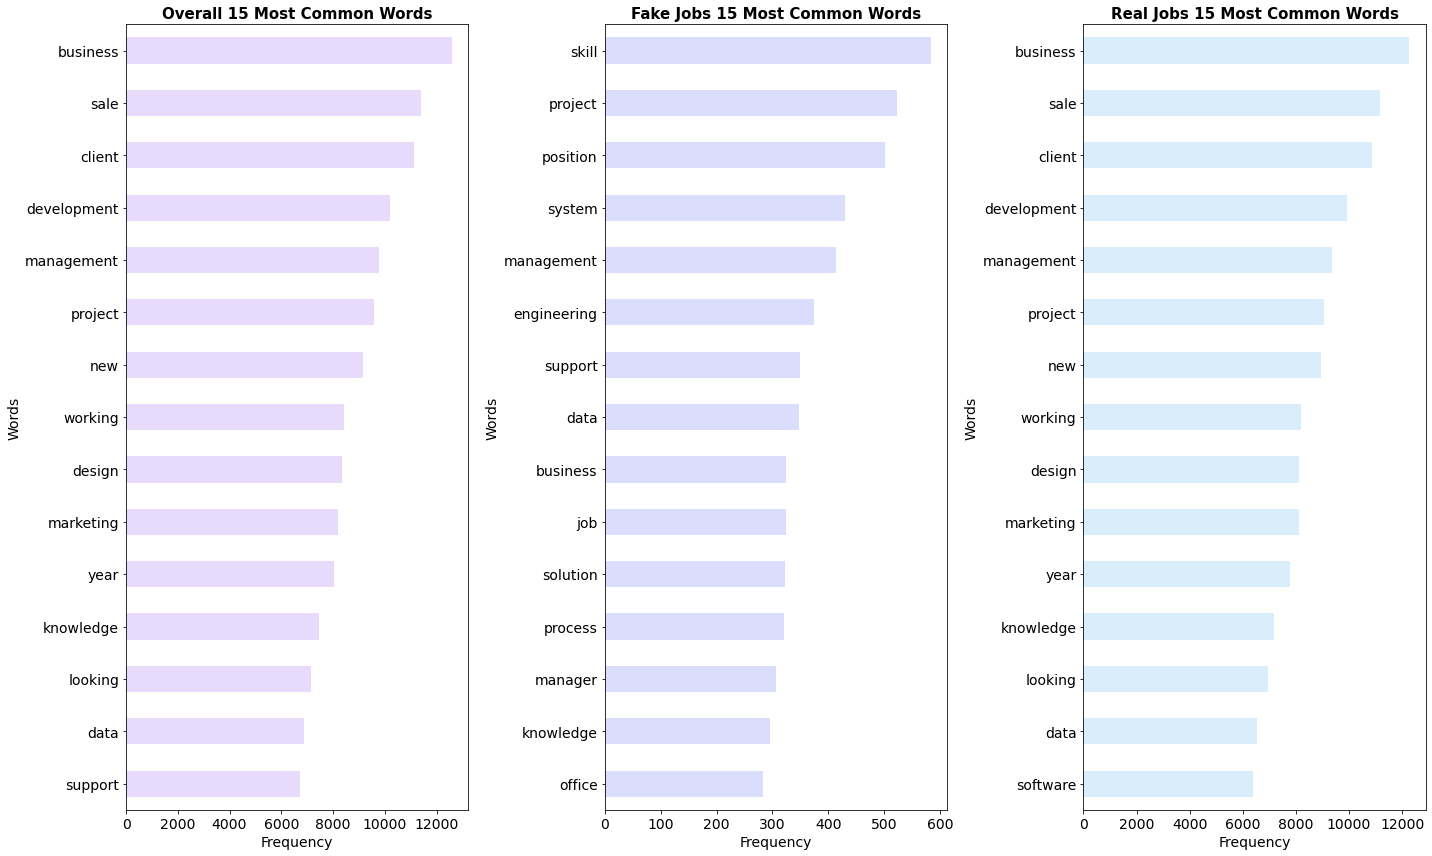

In [67]:
# plot top 15 common words
vect_plot('Common', 'Words', cvec_combined_df, cvec_fake_df, cvec_real_df)
plt.savefig('../image/count-vectorizer.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: There are several common words that exist in both fake and real jobs, e.g. `work, customer, service, team, product, company`. We will define these words as additional stopwords and remove them. _(Note: This is an iterative process so you may not see these words in the barcharts as we have removed them)._

In [68]:
# list of stopwords including self-defined ones
stopwords = nltk.corpus.stopwords.words('english')
    
# include additional stopwords which we want to remove
additional_stopwords = ['link', 'amp', 'email', 'address', 'apply', 'team', 'work', 'html', 'must', 'able',
                        'customer', 'service', 'product', 'company', 'ability', 'attention', 'detail', 'serif',
                        'communication', 'hour', 'per', 'week', 'year', 'experience', 'full', 'time', 'pm',
                        'either', 'entity', 'information', 'include', 'etc']
stopwords.extend(additional_stopwords)

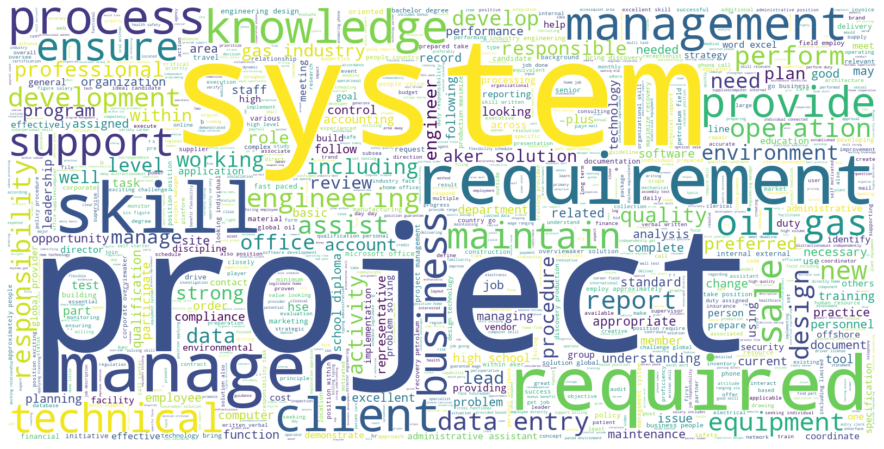

In [69]:
# wordcloud for fake jobs
plt.figure(figsize = (16,8))
stopwords = set(stopwords)
wc = WordCloud(background_color = "white", stopwords = stopwords, width = 1600, height = 800, 
               max_words = 1000).generate(" ".join(df[df.fraudulent == 1]['text_lemma']))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear');
plt.savefig('../image/fake-jobs-wordcloud.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

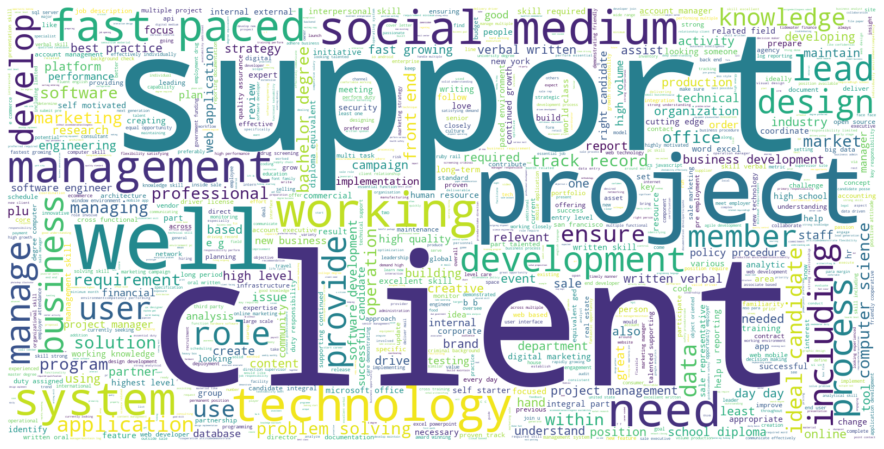

In [70]:
# wordcloud for real jobs
plt.figure(figsize = (16,8))
stopwords = set(stopwords)
wc = WordCloud(background_color = "white", stopwords = stopwords, width = 1600, height = 800, 
               max_words = 1000).generate(" ".join(df[df.fraudulent == 0]['text_lemma']))
plt.axis("off")
plt.imshow(wc , interpolation = 'bilinear');
plt.savefig('../image/real-jobs-wordcloud.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

#### Bigrams - Cvec. Combined Data
Bigrams work the same way as unigrams except that we are now analysing the text in word-pairs instead of individual words. Similarly, we used the min_df and max_df parameters to remove outliers (i.e. words that occur too frequently/too infrequently). In this case, we removed bigrams that appear more than 60% and less than 0.5% in the corpus.

In [71]:
# create an instance of cvec bigrams
bigram_cvec = CountVectorizer(min_df = 0.005, max_df = 0.6, ngram_range = (2,2))

# create a sparse matrix on text data of df
bigram_cvec_combined = bigram_cvec.fit_transform(df['text_lemma'])
print(bigram_cvec_combined.shape)
bigram_cvec_combined_df = pd.DataFrame(bigram_cvec_combined.toarray(), columns = bigram_cvec.get_feature_names())

(11867, 1831)


In [72]:
# display top 15 most common bigrams in df
bigram_cvec_combined_df.sum().sort_values(ascending = False).head(15)

social medium           1895
fast paced              1815
ideal candidate         1197
problem solving         1188
bachelor degree         1049
computer science        1037
minimum year            1022
track record            1009
business development     989
front end                987
project management       947
written verbal           932
best practice            922
verbal written           898
school diploma           897
dtype: int64

#### Bigrams - Cvec. Fake Jobs

In [73]:
# create a sparse matrix on text data of fake_jobs
bigram_cvec_fake = bigram_cvec.fit_transform(fake_jobs['text_lemma'])
print(bigram_cvec_fake.shape)
bigram_cvec_fake_df = pd.DataFrame(bigram_cvec_fake.toarray(), columns = bigram_cvec.get_feature_names())

(486, 5124)


In [74]:
# display top 15 most common bigrams in fake_jobs
bigram_cvec_fake_df.sum().sort_values(ascending = False).head(15)

oil gas                     168
data entry                  143
gas industry                105
aker solution                95
high school                  69
school diploma               59
administrative assistant     56
word excel                   50
engineering design           46
problem solving              46
global provider              46
fast paced                   46
internal external            45
microsoft office             44
provider product             43
dtype: int64

#### Bigrams - Cvec. Real Jobs

In [75]:
# create a sparse matrix on text data of real_jobs
bigram_cvec_real = bigram_cvec.fit_transform(real_jobs['text_lemma'])
print(bigram_cvec_real.shape)
bigram_cvec_real_df = pd.DataFrame(bigram_cvec_real.toarray(), columns = bigram_cvec.get_feature_names())

(11381, 1916)


In [76]:
# display top 15 most common bigrams in real_jobs
bigram_cvec_real_df.sum().sort_values(ascending = False).head(15)

social medium           1889
fast paced              1769
ideal candidate         1159
problem solving         1142
computer science        1021
bachelor degree         1007
track record             999
minimum year             995
front end                982
business development     978
best practice            909
project management       904
written verbal           894
verbal written           866
software development     850
dtype: int64

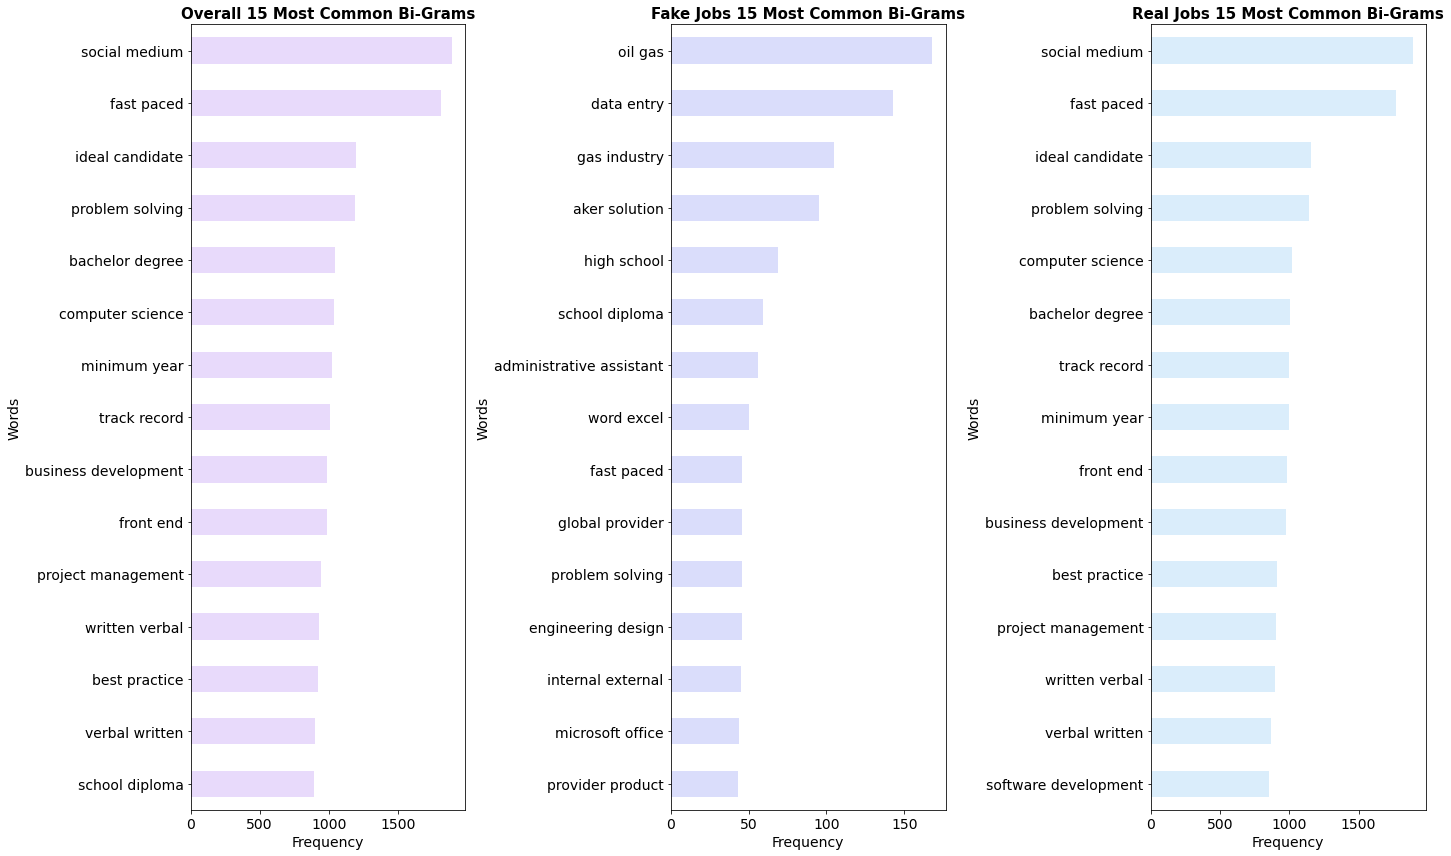

In [77]:
# plot top 15 common bigrams
vect_plot('Common', 'Bi-Grams', bigram_cvec_combined_df, bigram_cvec_fake_df, bigram_cvec_real_df)
plt.savefig('../image/bigrams-cvec.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: The top 15 bigrams are more insightful than individual words alone. From the plots, we can see that the top bigrams for fake jobs are `oil gas`, `data entry`, `gas industry`, `aker solution`. This could be a sign that these industries/jobs commonly have fake job ads, and job-seekers need to be more careful when applying for such roles.

There are also common bigrams in both real and fake job ads such as `communication skill, year experience, full time, attention detail`, which we will remove them as stopwords. _(Note: This is an iterative process so you may not see these words in the barcharts as we have removed them)._

#### Tri-Grams - Cvec. Combined Data
Trigrams work the same way as unigrams and bigrams except that we are now analysing the text in phrases (three consecutive words) instead of individual words or word-pairs. Similarly, we used the min_df and max_df parameters to remove outliers (i.e. words that occur too frequently/too infrequently). In this case, we removed trigrams that appear more than 60% and less than 0.5% in the corpus.

In [78]:
# create an instance of cvec trigrams
trigram_cvec = CountVectorizer(min_df = 0.005, max_df = 0.6, ngram_range = (3,3))

# create a sparse matrix on text data of df
trigram_cvec_combined = trigram_cvec.fit_transform(df['text_lemma'])
print(trigram_cvec_combined.shape)
trigram_cvec_combined_df = pd.DataFrame(trigram_cvec_combined.toarray(), columns = trigram_cvec.get_feature_names())

(11867, 542)


In [79]:
# display top 15 most common trigrams in df
trigram_cvec_combined_df.sum().sort_values(ascending = False).head(15)

fast paced environment             557
school diploma equivalent          519
high school diploma                471
candidate integral part            464
supporting continued growth        459
integral part talented             452
talented supporting continued      451
part talented supporting           451
right candidate integral           437
proven track record                415
diploma equivalent ged             383
degree computer science            379
continued growth responsibility    333
problem solving skill              330
equal opportunity employer         330
dtype: int64

#### Tri-Grams - Cvec. Fake Jobs

In [80]:
# create a sparse matrix on text data of fake_jobs
trigram_cvec_fake = trigram_cvec.fit_transform(fake_jobs['text_lemma'])
print(trigram_cvec_fake.shape)
trigram_cvec_fake_df = pd.DataFrame(trigram_cvec_fake.toarray(), columns = trigram_cvec.get_feature_names())

(486, 3888)


In [81]:
# display top 15 most common trigrams in fake_jobs
trigram_cvec_fake_df.sum().sort_values(ascending = False).head(15)

oil gas industry                 105
high school diploma               50
gas industry engineering          43
go business people                42
engineering design technology     42
people country go                 42
solution global provider          42
technology bring discovery        42
industry engineering design       42
discovery production maximize     42
employ approximately people       42
recovery petroleum field          42
business people value             42
design technology bring           42
maximize recovery petroleum       42
dtype: int64

#### Tri-Grams - Cvec. Real Jobs

In [82]:
# create a sparse matrix on text data of real_jobs
trigram_cvec_real = trigram_cvec.fit_transform(real_jobs['text_lemma'])
print(trigram_cvec_real.shape)
trigram_cvec_real_df = pd.DataFrame(trigram_cvec_real.toarray(), columns = trigram_cvec.get_feature_names())

(11381, 563)


In [83]:
# display top 15 most common trigrams in real_jobs
trigram_cvec_real_df.sum().sort_values(ascending = False).head(15)

fast paced environment             536
school diploma equivalent          504
candidate integral part            463
supporting continued growth        459
integral part talented             452
part talented supporting           451
talented supporting continued      451
right candidate integral           437
high school diploma                421
proven track record                411
diploma equivalent ged             383
degree computer science            375
continued growth responsibility    333
meet employer attendance           319
verbal written skill               316
dtype: int64

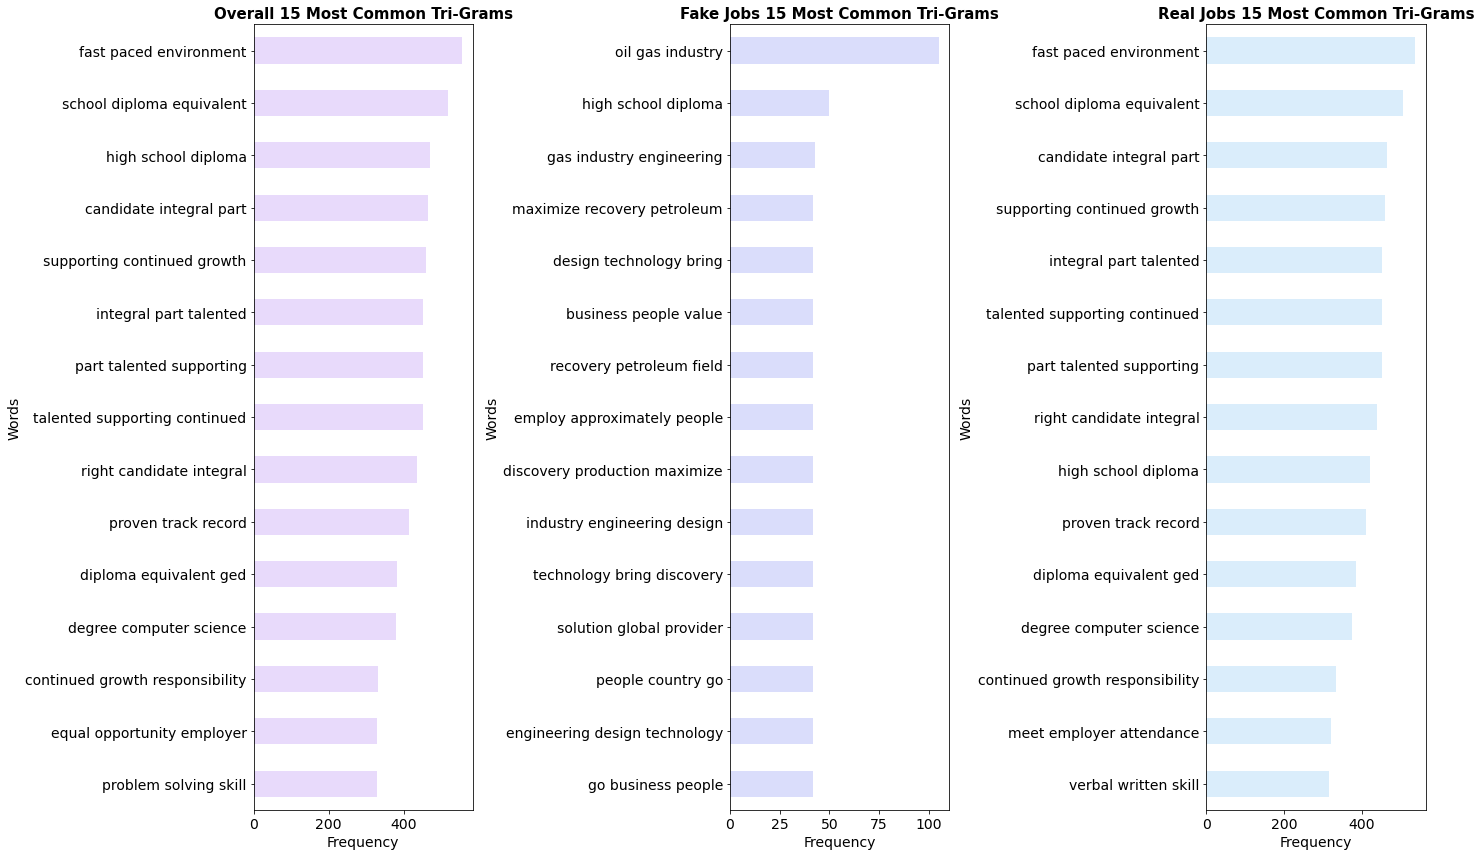

In [84]:
# plot top 15 common trigrams
vect_plot('Common', 'Tri-Grams', trigram_cvec_combined_df, trigram_cvec_fake_df, trigram_cvec_real_df)
plt.savefig('../image/trigrams-cvec.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: The top 15 trigrams does not seem to be very intuitive as it contains phrases like `people country go` and `go business people` which does not have any meaning. However, a point to note is that among fake jobs, `oil gas industry`, `high school diploma`, and `gas industry engineering` appears quite frequently. This is in line with our observation from the bigrams that oil gas industry could be an industry which candidates should avoid/scrutinize more thoroughly when they are intending to apply for jobs in those field.

### TFIDF Vectorization
TFIDF Vectorization is similar to Count Vectorization where it converts textual data to a sparse matrix that machine learning models can understand. However, it also includes some consideration for the length of the document, and how common the words are across the other texts.

#### Tvec. Combined Data
We used the min_df and max_df parameters in TFIDF vectorizer to remove outliers (i.e. words that occur too frequently/too infrequently). In this case, we removed words that appear more than 80% and words that appear less than 0.5% in the corpus.

In [85]:
# create instance of tfidf vectorizer
tvec = TfidfVectorizer(min_df = 0.005, max_df = 0.8)

# create a sparse matrix on text data of df
tvec_combined = tvec.fit_transform(df['text_lemma'])
print(tvec_combined.shape)
tvec_combined_df = pd.DataFrame(tvec_combined.toarray(), columns = tvec.get_feature_names())

(11867, 3086)


In [86]:
# display top 15 most important words in df
tvec_combined_df.sum().sort_values(ascending = False).head(15)

sale           465.390136
business       364.896361
client         362.558013
skill          348.809602
marketing      335.536535
development    327.375900
design         326.672863
project        319.852506
management     288.448822
new            277.660855
web            277.575879
data           273.241471
software       266.291642
working        263.917578
looking        248.931309
dtype: float64

#### Tvec. Fake Jobs

In [87]:
# create a sparse matrix on text data of fake_jobs
tvec_fake = tvec.fit_transform(fake_jobs['text_lemma'])
print(tvec_fake.shape)
tvec_fake_df = pd.DataFrame(tvec_fake.toarray(), columns = tvec.get_feature_names())

(486, 2947)


In [88]:
# display top 15 most important words in fake_jobs
tvec_fake_df.sum().sort_values(ascending = False).head(15)

position          17.887555
skill             17.268850
data              16.059487
project           16.006275
job               13.670939
office            13.285631
sale              12.839591
engineering       12.617726
entry             12.585704
home              12.528692
system            12.329993
administrative    12.261518
support           11.694539
management        11.677018
manager           11.074796
dtype: float64

#### Tvec. Real Jobs

In [89]:
# create a sparse matrix on text data of real_jobs
tvec_real = tvec.fit_transform(real_jobs['text_lemma'])
print(tvec_real.shape)
tvec_real_df = pd.DataFrame(tvec_real.toarray(), columns = tvec.get_feature_names())

(11381, 3113)


In [90]:
# display top 15 most important words in real_jobs
tvec_real_df.sum().sort_values(ascending = False).head(15)

sale           451.853042
business       354.020131
client         351.648576
skill          332.103533
marketing      329.422400
design         318.167172
development    317.917139
project        303.869183
management     276.673063
web            272.495938
new            269.548128
software       259.096337
data           257.943342
working        254.781400
looking        239.779280
dtype: float64

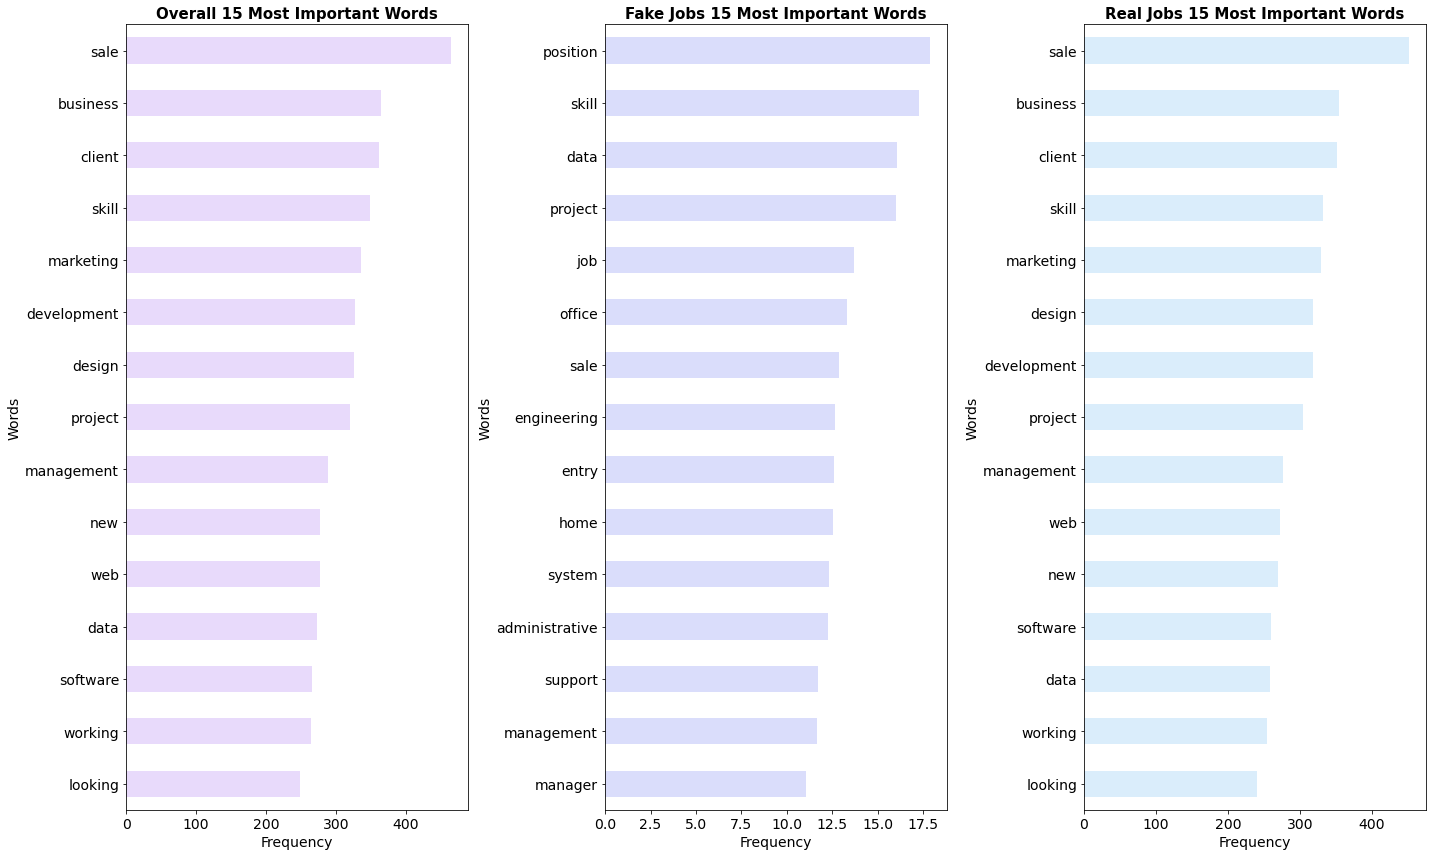

In [91]:
# plot top 15 important words
vect_plot('Important', 'Words', tvec_combined_df, tvec_fake_df, tvec_real_df)
plt.savefig('../image/tfidf-vectorizer.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: The important words from both fake jobs and real jobs appear to be generic.

#### Bi-Grams - Tvec. Combined Data
For bigrams, we removed word-pairs that appear more than 70% and less than 1% in the corpus.

In [92]:
# create instance of tfidf bigrams
bigram_tvec = TfidfVectorizer(min_df = 0.01, max_df = 0.7, ngram_range = (2,2))

# create a sparse matrix on text data of df
bigram_tvec_combined = bigram_tvec.fit_transform(df['text_lemma'])
print(bigram_tvec_combined.shape)
bigram_tvec_combined_df = pd.DataFrame(bigram_tvec_combined.toarray(), columns = bigram_tvec.get_feature_names())

(11867, 644)


In [93]:
# display top 15 most important bigrams in df
bigram_tvec_combined_df.sum().sort_values(ascending = False).head(15)

social medium           321.137702
fast paced              287.693446
ideal candidate         233.165873
bachelor degree         212.650884
problem solving         211.691688
minimum year            200.146118
front end               197.430154
computer science        196.126243
track record            190.732846
business development    188.662566
least year              186.911688
best practice           180.002460
written verbal          176.266265
project management      171.782783
day day                 170.509735
dtype: float64

#### Bi-Grams - Tvec. Fake Jobs

In [94]:
# create a sparse matrix on text data of fake_jobs
bigram_tvec_fake = bigram_tvec.fit_transform(fake_jobs['text_lemma'])
print(bigram_tvec_fake.shape)
bigram_tvec_fake_df = pd.DataFrame(bigram_tvec_fake.toarray(), columns = bigram_tvec.get_feature_names())

(486, 1518)


In [95]:
# display top 15 most important bigrams in fake_jobs
bigram_tvec_fake_df.sum().sort_values(ascending = False).head(15)

data entry                  19.638947
oil gas                     11.953668
high school                 11.743886
administrative assistant     9.975095
school diploma               9.820247
gas industry                 7.965904
long term                    7.640672
fast paced                   7.543689
word excel                   7.159276
problem solving              7.079501
aker solution                7.002346
ideal candidate              6.555376
microsoft office             6.082767
policy procedure             6.003587
duty assigned                5.916127
dtype: float64

#### Bi-Grams - Tvec. Real Jobs

In [96]:
# create a sparse matrix on text data of real_jobs
bigram_tvec_real = bigram_tvec.fit_transform(real_jobs['text_lemma'])
print(bigram_tvec_real.shape)
bigram_tvec_real_df = pd.DataFrame(bigram_tvec_real.toarray(), columns = bigram_tvec.get_feature_names())

(11381, 655)


In [97]:
# display top 15 most important bigrams in real_jobs
bigram_tvec_real_df.sum().sort_values(ascending = False).head(15)

social medium           315.628506
fast paced              276.681730
ideal candidate         220.564142
problem solving         203.086141
bachelor degree         201.866631
front end               195.690496
minimum year            194.149819
computer science        191.050045
track record            186.780184
business development    182.669108
least year              180.720584
best practice           176.658907
written verbal          166.841663
software engineer       164.987705
fast growing            164.682326
dtype: float64

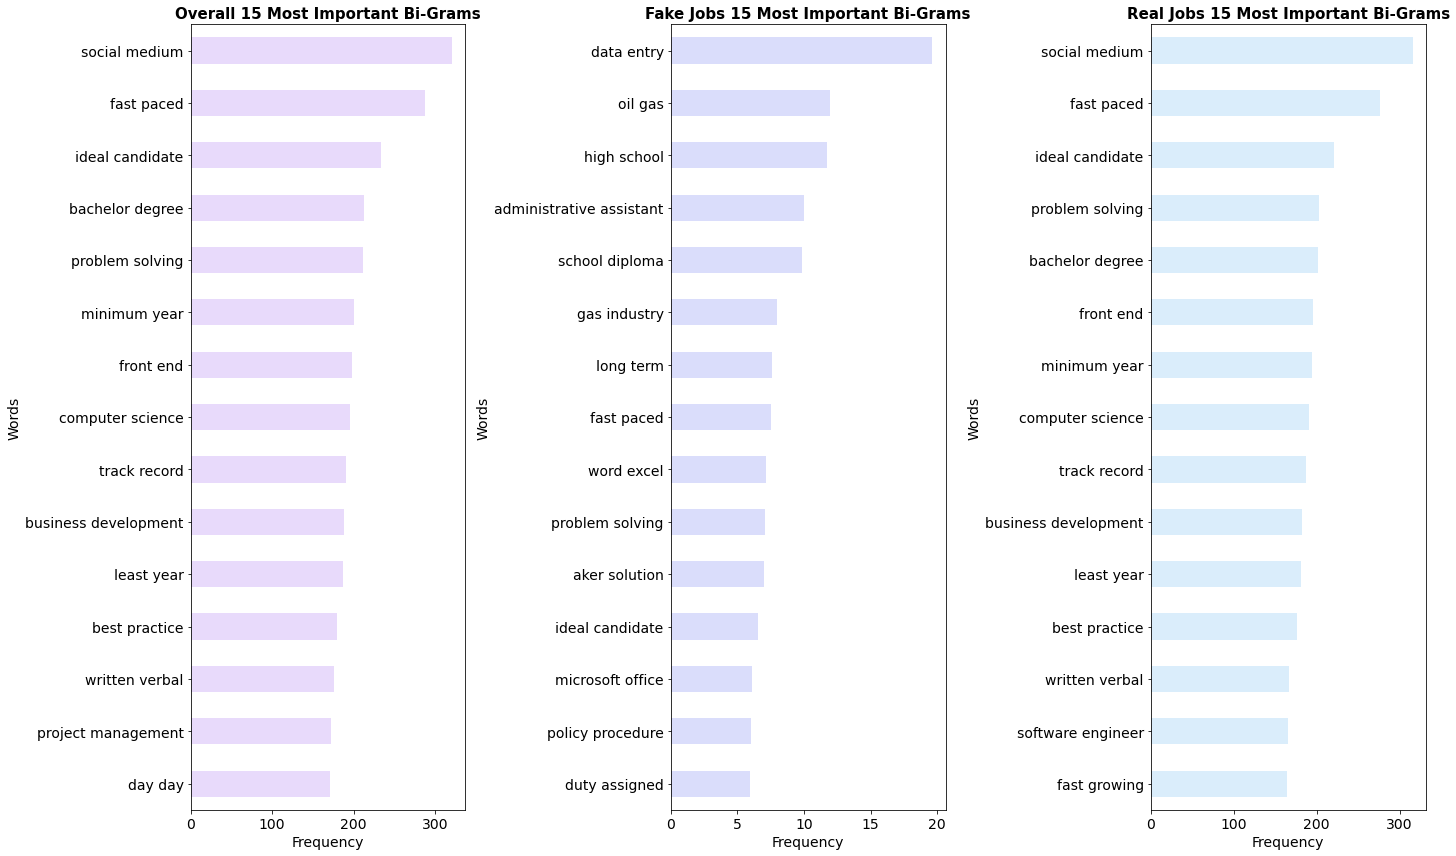

In [98]:
# plot top 15 important bigrams
vect_plot('Important', 'Bi-Grams', bigram_tvec_combined_df, bigram_tvec_fake_df, bigram_tvec_real_df)
plt.savefig('../image/bigrams-tvec.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: The most important bigrams from both fake jobs/real jobs appear to be distinctively different, which is good. 

#### Tri-Grams - Tvec. Combined Data
For trigrams, we removed phrases (three consecutive words) that appear more than 80% and less than 1% in the corpus.

In [99]:
# create instance of tfidf trigrams
trigram_tvec = TfidfVectorizer(min_df = 0.01, max_df = 0.8, ngram_range = (3,3))

# create a sparse matrix on text data of df
trigram_tvec_combined = trigram_tvec.fit_transform(df['text_lemma'])
print(trigram_tvec_combined.shape)
trigram_tvec_combined_df = pd.DataFrame(trigram_tvec_combined.toarray(), columns = trigram_tvec.get_feature_names())

(11867, 195)


In [100]:
# display top 15 most important trigrams in df
trigram_tvec_combined_df.sum().sort_values(ascending = False).head(15)

fast paced environment        394.686699
proven track record           344.156210
degree computer science       273.855198
high school diploma           250.614811
equal opportunity employer    224.876027
written verbal skill          221.480810
problem solving skill         215.922431
verbal written skill          212.035546
computer science related      157.658599
valid driver license          147.567906
front end developer           142.650732
excellent verbal written      140.260811
school diploma equivalent     139.615116
excellent written verbal      125.855247
analytical problem solving    122.955538
dtype: float64

#### Tri-Grams - Tvec. Fake Jobs

In [101]:
# create a sparse matrix on text data of fake_jobs
trigram_tvec_fake = trigram_tvec.fit_transform(fake_jobs['text_lemma'])
print(trigram_tvec_fake.shape)
trigram_tvec_fake_df = pd.DataFrame(trigram_tvec_fake.toarray(), columns = trigram_tvec.get_feature_names())

(486, 849)


In [102]:
# display top 15 most important trigrams in fake_jobs
trigram_tvec_fake_df.sum().sort_values(ascending = False).head(15)

high school diploma              24.993943
oil gas industry                 11.457925
fast paced environment           11.284592
problem solving skill             7.946043
school diploma equivalent         7.836883
equal opportunity employer        7.019228
word excel powerpoint             6.690279
get job done                      6.566972
school diploma ged                6.147184
essential duty responsibility     5.999391
oral written skill                5.341592
data entry clerk                  5.265032
internal external customer        5.160431
microsoft word excel              5.028314
data entry skill                  5.018698
dtype: float64

#### Tri-Grams - Tvec. Real Jobs

In [103]:
# create a sparse matrix on text data of real_jobs
trigram_tvec_real = trigram_tvec.fit_transform(real_jobs['text_lemma'])
print(trigram_tvec_real.shape)
trigram_tvec_real_df = pd.DataFrame(trigram_tvec_real.toarray(), columns = trigram_tvec.get_feature_names())

(11381, 199)


In [104]:
# display top 15 most important trigrams in real_jobs
trigram_tvec_real_df.sum().sort_values(ascending = False).head(15)

fast paced environment        380.594733
proven track record           340.418979
degree computer science       270.260119
written verbal skill          213.501953
high school diploma           211.245811
verbal written skill          207.039667
problem solving skill         206.269474
equal opportunity employer    201.504675
computer science related      153.499416
front end developer           142.610725
valid driver license          140.372294
excellent verbal written      133.145216
school diploma equivalent     128.207105
excellent written verbal      121.336971
one fastest growing           120.820201
dtype: float64

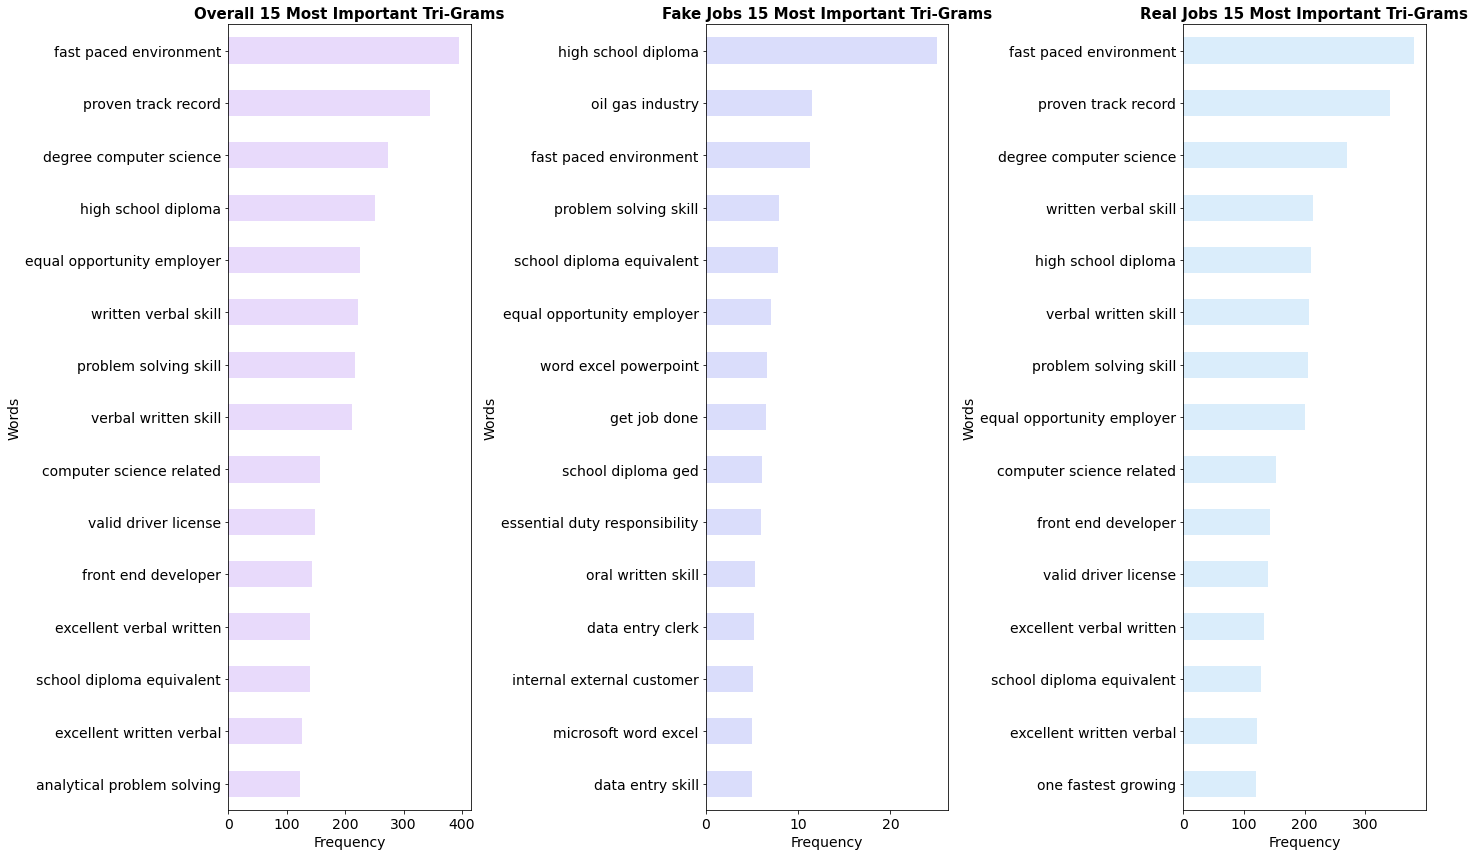

In [105]:
# plot top 15 important trigrams
vect_plot('Important', 'Tri-Grams', trigram_tvec_combined_df, trigram_tvec_fake_df, trigram_tvec_real_df)
plt.savefig('../image/trigrams-tvec.png', dpi = 'figure', bbox_inches = 'tight', facecolor = (1, 1, 1))

**Observation**: Similarly, the most important trigrams appear to be different. For fake jobs, the requirements are generally lower such as only requiring a high school diploma, with skills such as microsoft word, powerpoint and excel, which most people would already have some basic understanding of it. On the other hand, the requirements for real jobs are higher such as requiring a degree and skills in computer-science/front-end developer.

In [106]:
# export clean dataframe
df.to_csv('../data/clean_fake_job_postings.csv', index = False)